In [23]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomRotation, Normalize
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline


In [44]:
# Hyper-parameters
num_layers = 2
num_classes = 10
batch_size = 256
epochs = 10
learning_rate = 0.1
batches_show=128

In [84]:
transform = transforms.Compose([RandomHorizontalFlip(), 
                                RandomRotation(15), 
                                ToTensor(), 
#                                 Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                               ])

In [85]:
root = './'
# CIFAR 100
train_dataset = torchvision.datasets.CIFAR100(root, train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.CIFAR100(root, train=False, transform=transform, download=True)
print(len(train_dataset), len(test_dataset))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

print("Loading is done")

Files already downloaded and verified
Files already downloaded and verified
50000 10000
Loading is done


In [ ]:
# # Load the pretrained model
# model = models.resnet18(pretrained=True)

In [ ]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [ ]:
# model = freeze_layers(model, 'layer2')
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [ ]:
# for param in model.layer1.parameters():
#     param.requires_grad = False

In [47]:
def draw_loss_curve(histories, legends, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for key in histories[0][0].keys():
        if key != "epoch":
            plt.figure()
            plt.title(key)
            for history in histories:
                x = [h["epoch"] for h in history]
                y = [h[key] for h in history]
                # plt.ylim(ymin=0, ymax=3.0)
                plt.plot(x, y)
            plt.legend(legends)
            plt.savefig(os.path.join(save_dir, key + ".png"))


def cal_acc(out, label):
    batch_size = label.shape[0]
    pred = torch.argmax(out, dim=1)
    num_true = torch.nonzero(pred == label).shape[0]
    acc = num_true / batch_size
    return torch.tensor(acc)


class LrManager(optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, lrs):
        def f(epoch):
            rate = 1
            for k in sorted(lrs.keys()):
                if epoch >= k:
                    rate = lrs[k]
                else:
                    break
            return rate
        super(LrManager, self).__init__(optimizer, f)

### Define a training loop to train in a more convinient way

In [52]:
def train_model():
    global history
    history = []
    model.train()
    for epoch in range(epochs):
        print("\n-------------------  TRAINING  -------------------")
        loss_train = 0.0
        running_loss = 0.0
        acc_train = 0.0
        running_acc = 0.0
        for batch, data in enumerate(train_loader, 1):
            img, label = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            pred = model(img)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_train += loss.item()
            acc = cal_acc(pred, label)
            running_acc += acc.item()
            acc_train += acc.item()

            if batch % batches_show == 0:
                print(f"epoch: {epoch}, batch: {batch}, loss: {running_loss/batches_show:.4f}, acc: {running_acc/batches_show:.4f}")
                running_loss = 0.0
                running_acc = 0.0
        loss_train = loss_train / batch
        acc_train = acc_train / batch
        lr_scheduler.step()

#         print("------------------- LOSS CURVES -------------------")
        with torch.no_grad():
            running_acc = 0.0
            for batch, data in enumerate(test_loader, 1):
                img, label = data[0].to(device), data[1].to(device)
                pred = model(img)
                acc = cal_acc(pred, label)
                running_acc += acc.item()
            acc_val = running_acc / batch
#             print(f"epoch: {epoch}, acc_val: {acc_val:.4f}")

        history.append({"epoch": epoch, "loss_train": loss_train, "acc_train": acc_train, "acc_val": acc_val})
    print("------------------- LOSS CURVES -------------------")
    draw_loss_curve([history], legends=[f"resnet18-CIFAR100"], save_dir=f"history/resnet18-CIFAR100[{datetime.now()}]")

In [50]:
number_classes = 100
classes = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle',
            'bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair',
            'chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish',
            'forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion',
            'lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid',
            'otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit',
            'raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk',
            'skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank',
            'telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale',
            'willow_tree','wolf','woman','worm']

In [64]:
def test_model():
    confusion_matrix = np.zeros((number_classes, number_classes))
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            labels = labels.to(device)
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

    plt.figure(figsize=(30,30))

    classes_names = classes
    df_cm = pd.DataFrame(confusion_matrix, index=classes_names, columns=classes_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=70, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Define a function that can return the model depending on which layer to exclude when frozen another. 

In [55]:
def freeze_layers(except_layer):
    model = models.resnet18(pretrained=True).to(device)
    if except_layer != 0:
        layers = ['layer1', 'layer2', 'layer3', 'layer4']
        for name, child in model.named_children():
            if name in layers and name != except_layer:
                for param in child.parameters():
                    param.requires_grad = False
    
    return model

### Train only with layer1

In [96]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    print("warning: CUDA is not available, using CPU instead")
    
except_layer = 'layer1'
PATH_to_save = f'./cifar_net_only_{except_layer}.pth' 
model = freeze_layers(except_layer)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
lr_scheduler = LrManager(optimizer, {0: 1.0, 50: 0.3, 100: 0.1, 150: 0.03, 200: 0.01})
criterion = nn.CrossEntropyLoss()

# Show frozen layers
print("Example of working freezing the layers")
for name, param in model.named_parameters():
    print(name, param.requires_grad)

Example of working freezing the layers
conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.

Train model having only layer1 

-------------------  TRAINING  -------------------
epoch: 0, batch: 128, loss: 5.5193, acc: 0.0262

-------------------  TRAINING  -------------------
epoch: 1, batch: 128, loss: 5.0140, acc: 0.0351

-------------------  TRAINING  -------------------
epoch: 2, batch: 128, loss: 4.7909, acc: 0.0470

-------------------  TRAINING  -------------------
epoch: 3, batch: 128, loss: 4.6689, acc: 0.0633

-------------------  TRAINING  -------------------
epoch: 4, batch: 128, loss: 4.5050, acc: 0.0718

-------------------  TRAINING  -------------------
epoch: 5, batch: 128, loss: 4.4182, acc: 0.0854

-------------------  TRAINING  -------------------
epoch: 6, batch: 128, loss: 4.3351, acc: 0.0907

-------------------  TRAINING  -------------------
epoch: 7, batch: 128, loss: 4.3499, acc: 0.0929

-------------------  TRAINING  -------------------
epoch: 8, batch: 128, loss: 4.1996, acc: 0.1013

-------------------  TRAINING  -------------------
epoch: 9, batch:

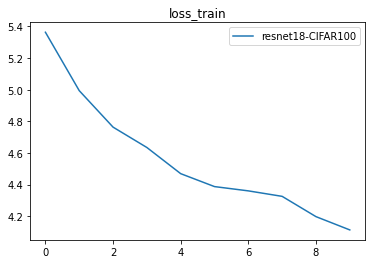

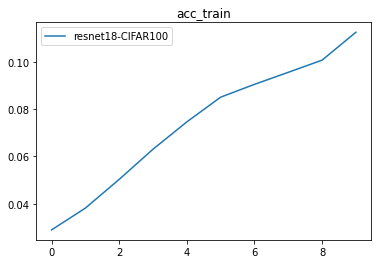

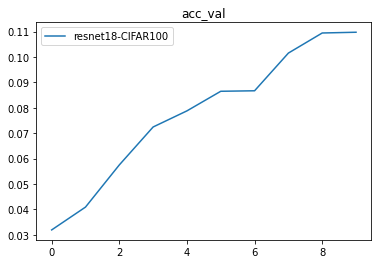

In [97]:
%%time
print("Train model having only %s " % except_layer)
train_model()
history_layer1 = history

### Show confusion matrix

Test Accuracy of the model on the 10000 test images: 11.04 %


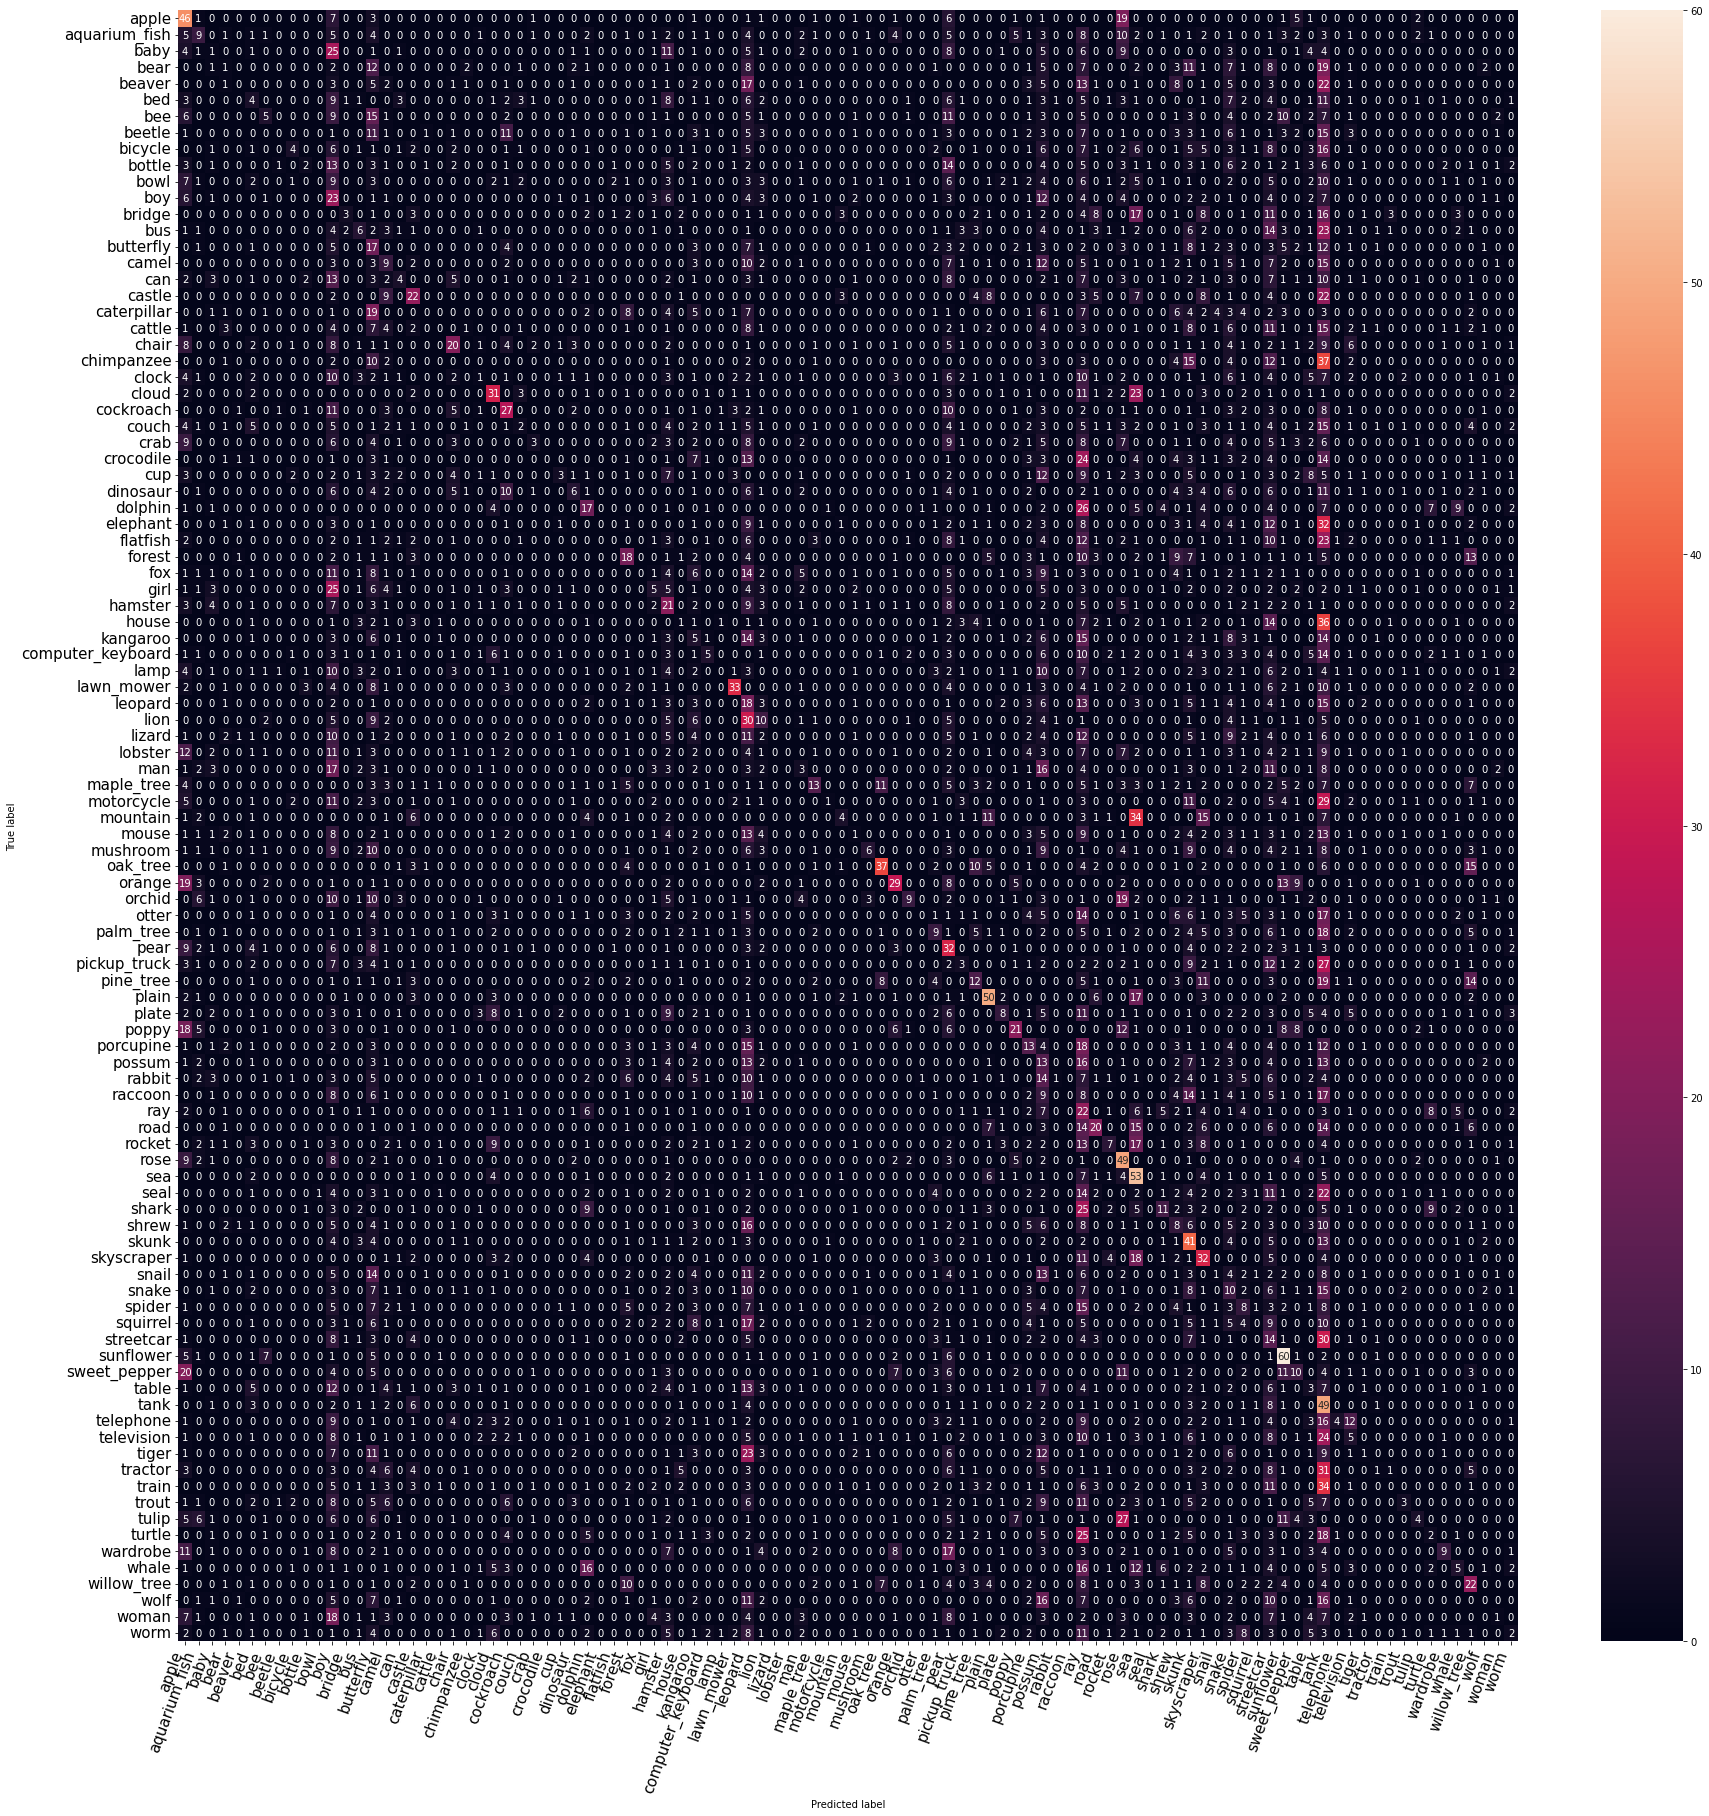

In [98]:
# The output of plot can take a time, because there are 100 classes
test_model()

In [99]:
print(history_layer1)

[{'epoch': 0, 'loss_train': 5.363331544155977, 'acc_train': 0.02893813775510204, 'acc_val': 0.03193359375}, {'epoch': 1, 'loss_train': 4.993954636612717, 'acc_train': 0.03816964285809318, 'acc_val': 0.04091796875}, {'epoch': 2, 'loss_train': 4.7632723122226945, 'acc_train': 0.05031090561414556, 'acc_val': 0.05751953125}, {'epoch': 3, 'loss_train': 4.634471126965114, 'acc_train': 0.06307796556122448, 'acc_val': 0.0724609375}, {'epoch': 4, 'loss_train': 4.469011786032696, 'acc_train': 0.07463329082012785, 'acc_val': 0.07880859375}, {'epoch': 5, 'loss_train': 4.387211431045921, 'acc_train': 0.085096460462985, 'acc_val': 0.0865234375}, {'epoch': 6, 'loss_train': 4.360148184153498, 'acc_train': 0.09051737883033192, 'acc_val': 0.08671875}, {'epoch': 7, 'loss_train': 4.325461719717298, 'acc_train': 0.095611447696479, 'acc_val': 0.1015625}, {'epoch': 8, 'loss_train': 4.197232026226667, 'acc_train': 0.10076530612244898, 'acc_val': 0.10947265625}, {'epoch': 9, 'loss_train': 4.113236691270556, 'a

### Train model only with layer2

In [100]:
except_layer = 'layer2'
PATH_to_save = f'./cifar_net_only_{except_layer}.pth' 
model = freeze_layers(except_layer)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
lr_scheduler = LrManager(optimizer, {0: 1.0, 50: 0.3, 100: 0.1, 150: 0.03, 200: 0.01})
criterion = nn.CrossEntropyLoss()

Train model having only layer2

-------------------  TRAINING  -------------------
epoch: 0, batch: 128, loss: 5.2760, acc: 0.0198

-------------------  TRAINING  -------------------
epoch: 1, batch: 128, loss: 4.6864, acc: 0.0411

-------------------  TRAINING  -------------------
epoch: 2, batch: 128, loss: 4.5017, acc: 0.0598

-------------------  TRAINING  -------------------
epoch: 3, batch: 128, loss: 4.2761, acc: 0.0789

-------------------  TRAINING  -------------------
epoch: 4, batch: 128, loss: 4.2120, acc: 0.0876

-------------------  TRAINING  -------------------
epoch: 5, batch: 128, loss: 4.1032, acc: 0.1051

-------------------  TRAINING  -------------------
epoch: 6, batch: 128, loss: 3.9279, acc: 0.1278

-------------------  TRAINING  -------------------
epoch: 7, batch: 128, loss: 3.8297, acc: 0.1424

-------------------  TRAINING  -------------------
epoch: 8, batch: 128, loss: 3.8368, acc: 0.1404

-------------------  TRAINING  -------------------
epoch: 9, batch: 

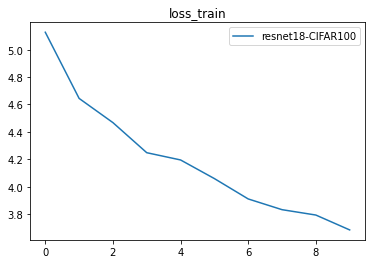

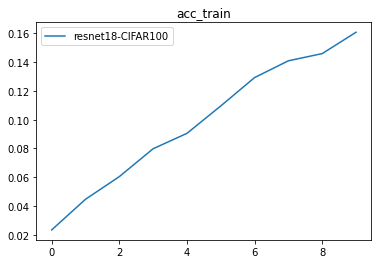

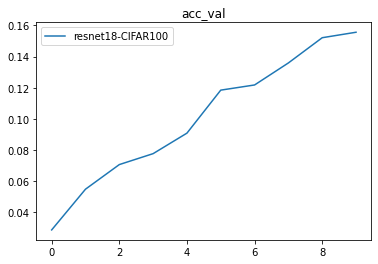

In [101]:
%%time
print("Train model having only %s" % except_layer)
train_model()
history_layer2 = history

### Show confusion matrix

Test Accuracy of the model on the 10000 test images: 16.16 %


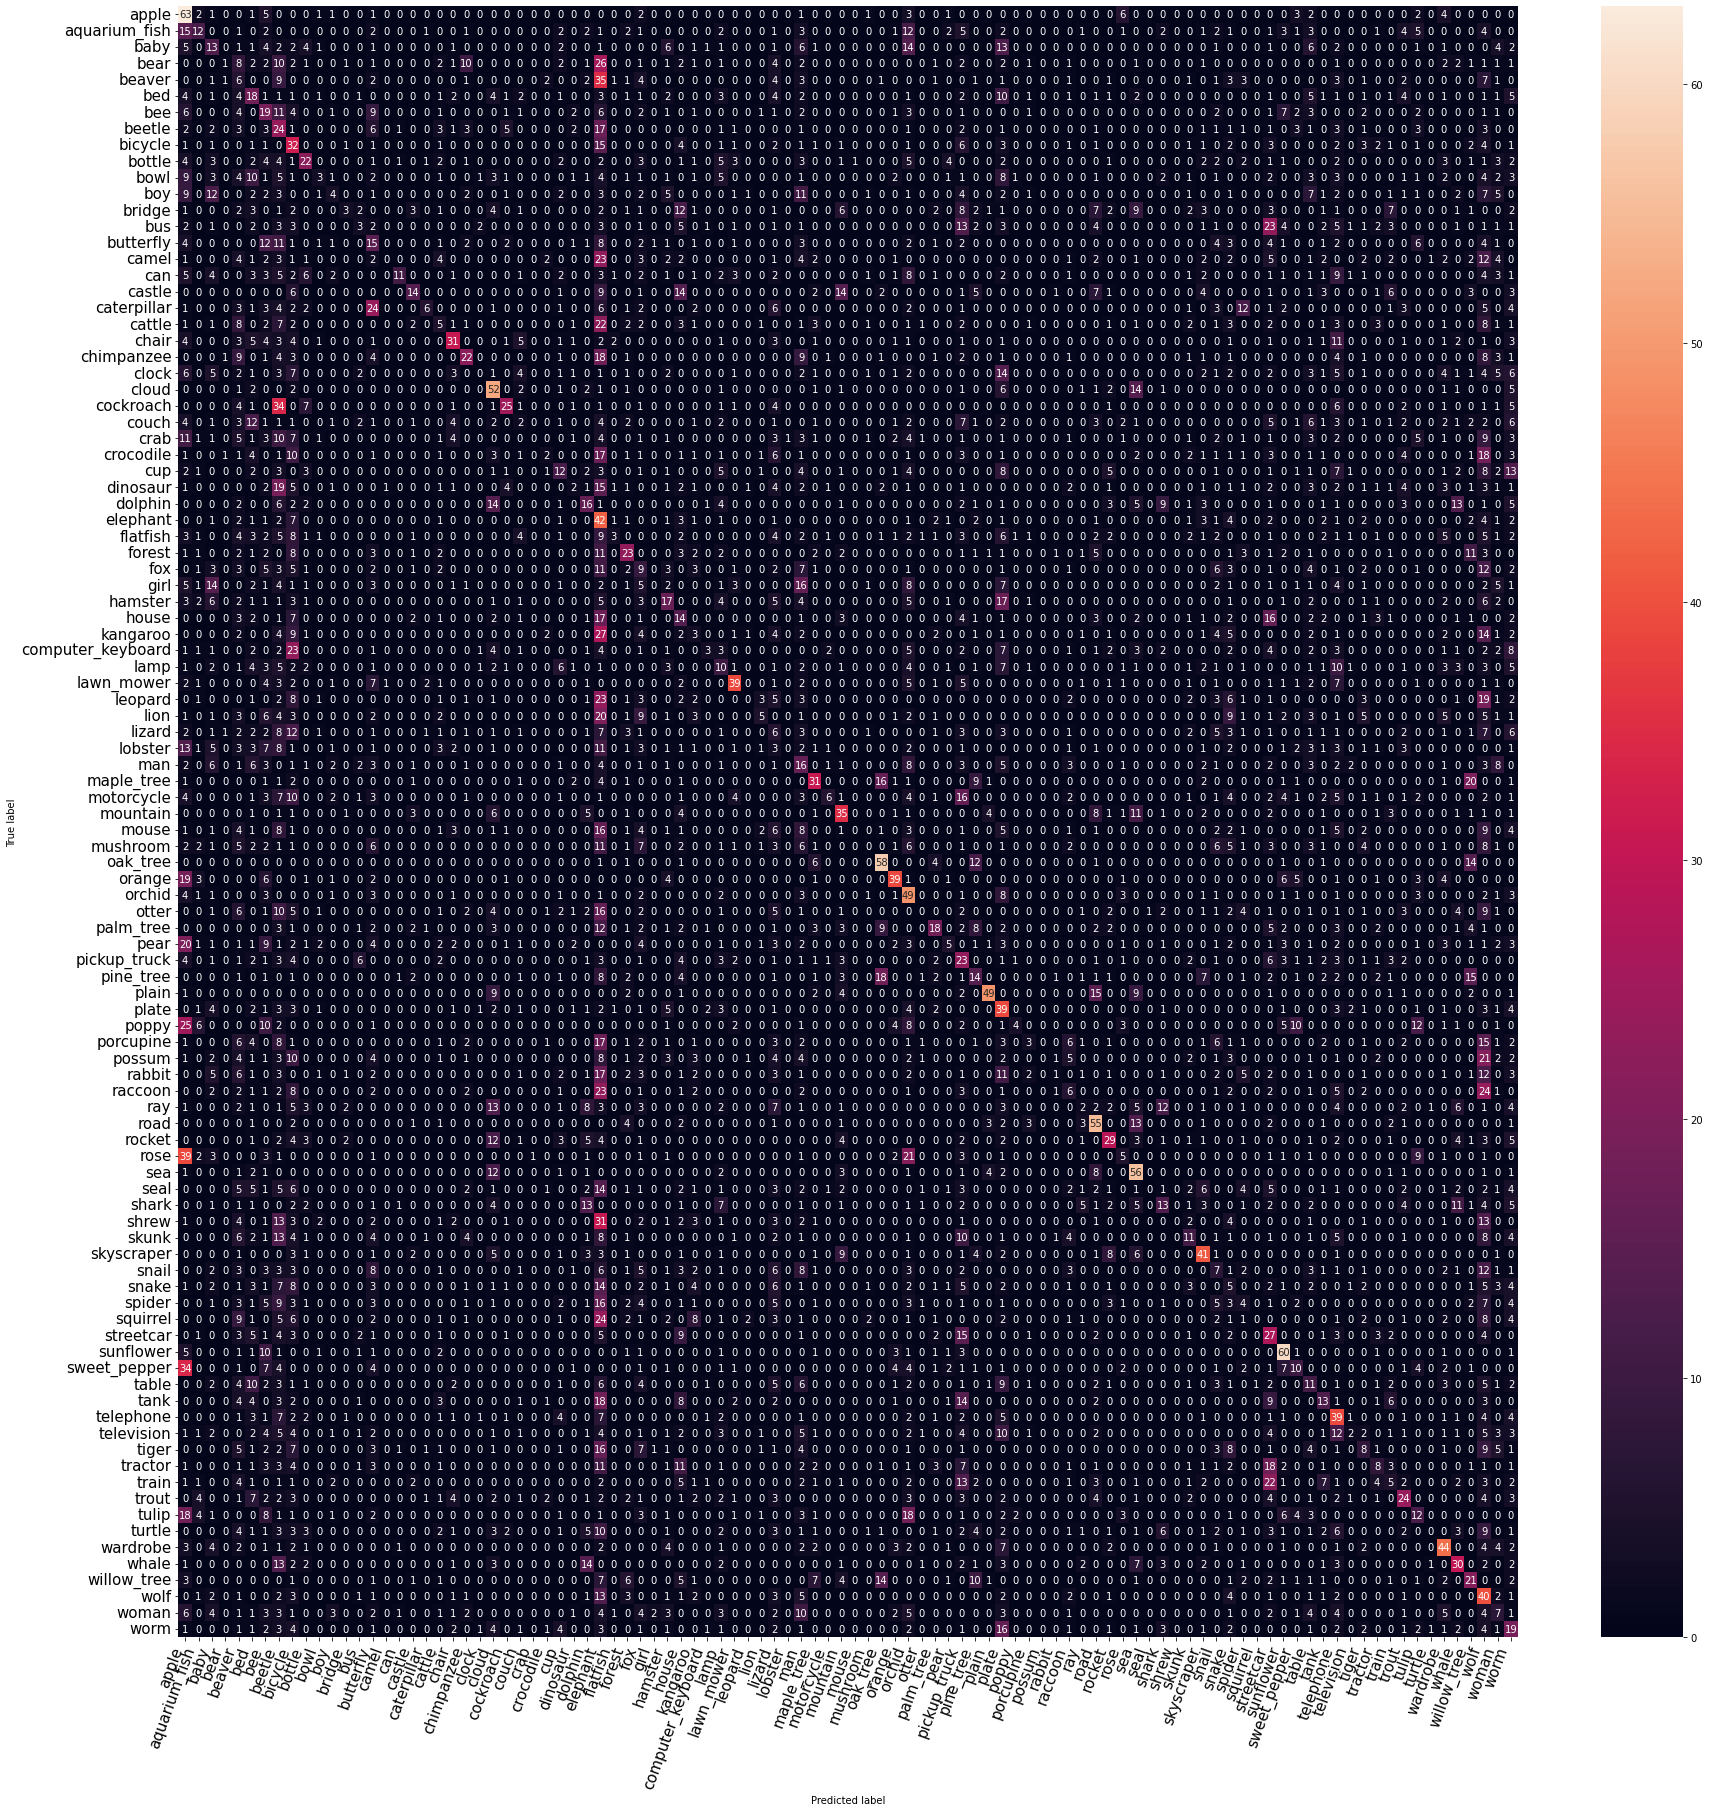

In [102]:
test_model()

In [103]:
print(history_layer2)

[{'epoch': 0, 'loss_train': 5.127234091564101, 'acc_train': 0.0233577806122449, 'acc_val': 0.02861328125}, {'epoch': 1, 'loss_train': 4.64422113311534, 'acc_train': 0.044654815058623044, 'acc_val': 0.05478515625}, {'epoch': 2, 'loss_train': 4.4674681680543085, 'acc_train': 0.06040736607142857, 'acc_val': 0.07060546875}, {'epoch': 3, 'loss_train': 4.24795819788563, 'acc_train': 0.07980309311319522, 'acc_val': 0.07763671875}, {'epoch': 4, 'loss_train': 4.194995645357638, 'acc_train': 0.09049346297979355, 'acc_val': 0.0908203125}, {'epoch': 5, 'loss_train': 4.059024545611168, 'acc_train': 0.1095463966912761, 'acc_val': 0.11845703125}, {'epoch': 6, 'loss_train': 3.9103884198227705, 'acc_train': 0.12927694516066385, 'acc_val': 0.12177734375}, {'epoch': 7, 'loss_train': 3.832121810134576, 'acc_train': 0.14094387755102042, 'acc_val': 0.1359375}, {'epoch': 8, 'loss_train': 3.7928961746546688, 'acc_train': 0.1459542411018391, 'acc_val': 0.1521484375}, {'epoch': 9, 'loss_train': 3.68431639671325

### Train model only with layer3

In [86]:
except_layer = 'layer3'
PATH_to_save = f'./cifar_net_only_{except_layer}.pth' 
model = freeze_layers(except_layer)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
lr_scheduler = LrManager(optimizer, {0: 1.0, 50: 0.3, 100: 0.1, 150: 0.03, 200: 0.01})
criterion = nn.CrossEntropyLoss()

Train model having only layer3

-------------------  TRAINING  -------------------
epoch: 0, batch: 128, loss: 4.9045, acc: 0.0268

-------------------  TRAINING  -------------------
epoch: 1, batch: 128, loss: 4.0244, acc: 0.0914

-------------------  TRAINING  -------------------
epoch: 2, batch: 128, loss: 3.6589, acc: 0.1518

-------------------  TRAINING  -------------------
epoch: 3, batch: 128, loss: 3.3651, acc: 0.1986

-------------------  TRAINING  -------------------
epoch: 4, batch: 128, loss: 3.1802, acc: 0.2315

-------------------  TRAINING  -------------------
epoch: 5, batch: 128, loss: 2.9745, acc: 0.2733

-------------------  TRAINING  -------------------
epoch: 6, batch: 128, loss: 2.8397, acc: 0.2988

-------------------  TRAINING  -------------------
epoch: 7, batch: 128, loss: 2.7428, acc: 0.3154

-------------------  TRAINING  -------------------
epoch: 8, batch: 128, loss: 2.6654, acc: 0.3345

-------------------  TRAINING  -------------------
epoch: 9, batch: 

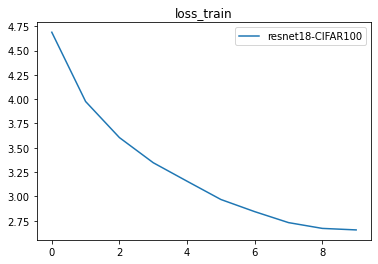

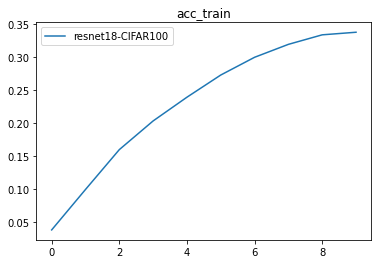

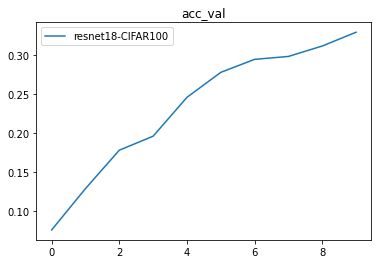

In [87]:
%%time
print("Train model having only %s" % except_layer)
train_model()
history_layer3 = history

### Show confusion matrix

Test Accuracy of the model on the 10000 test images: 33.45 %


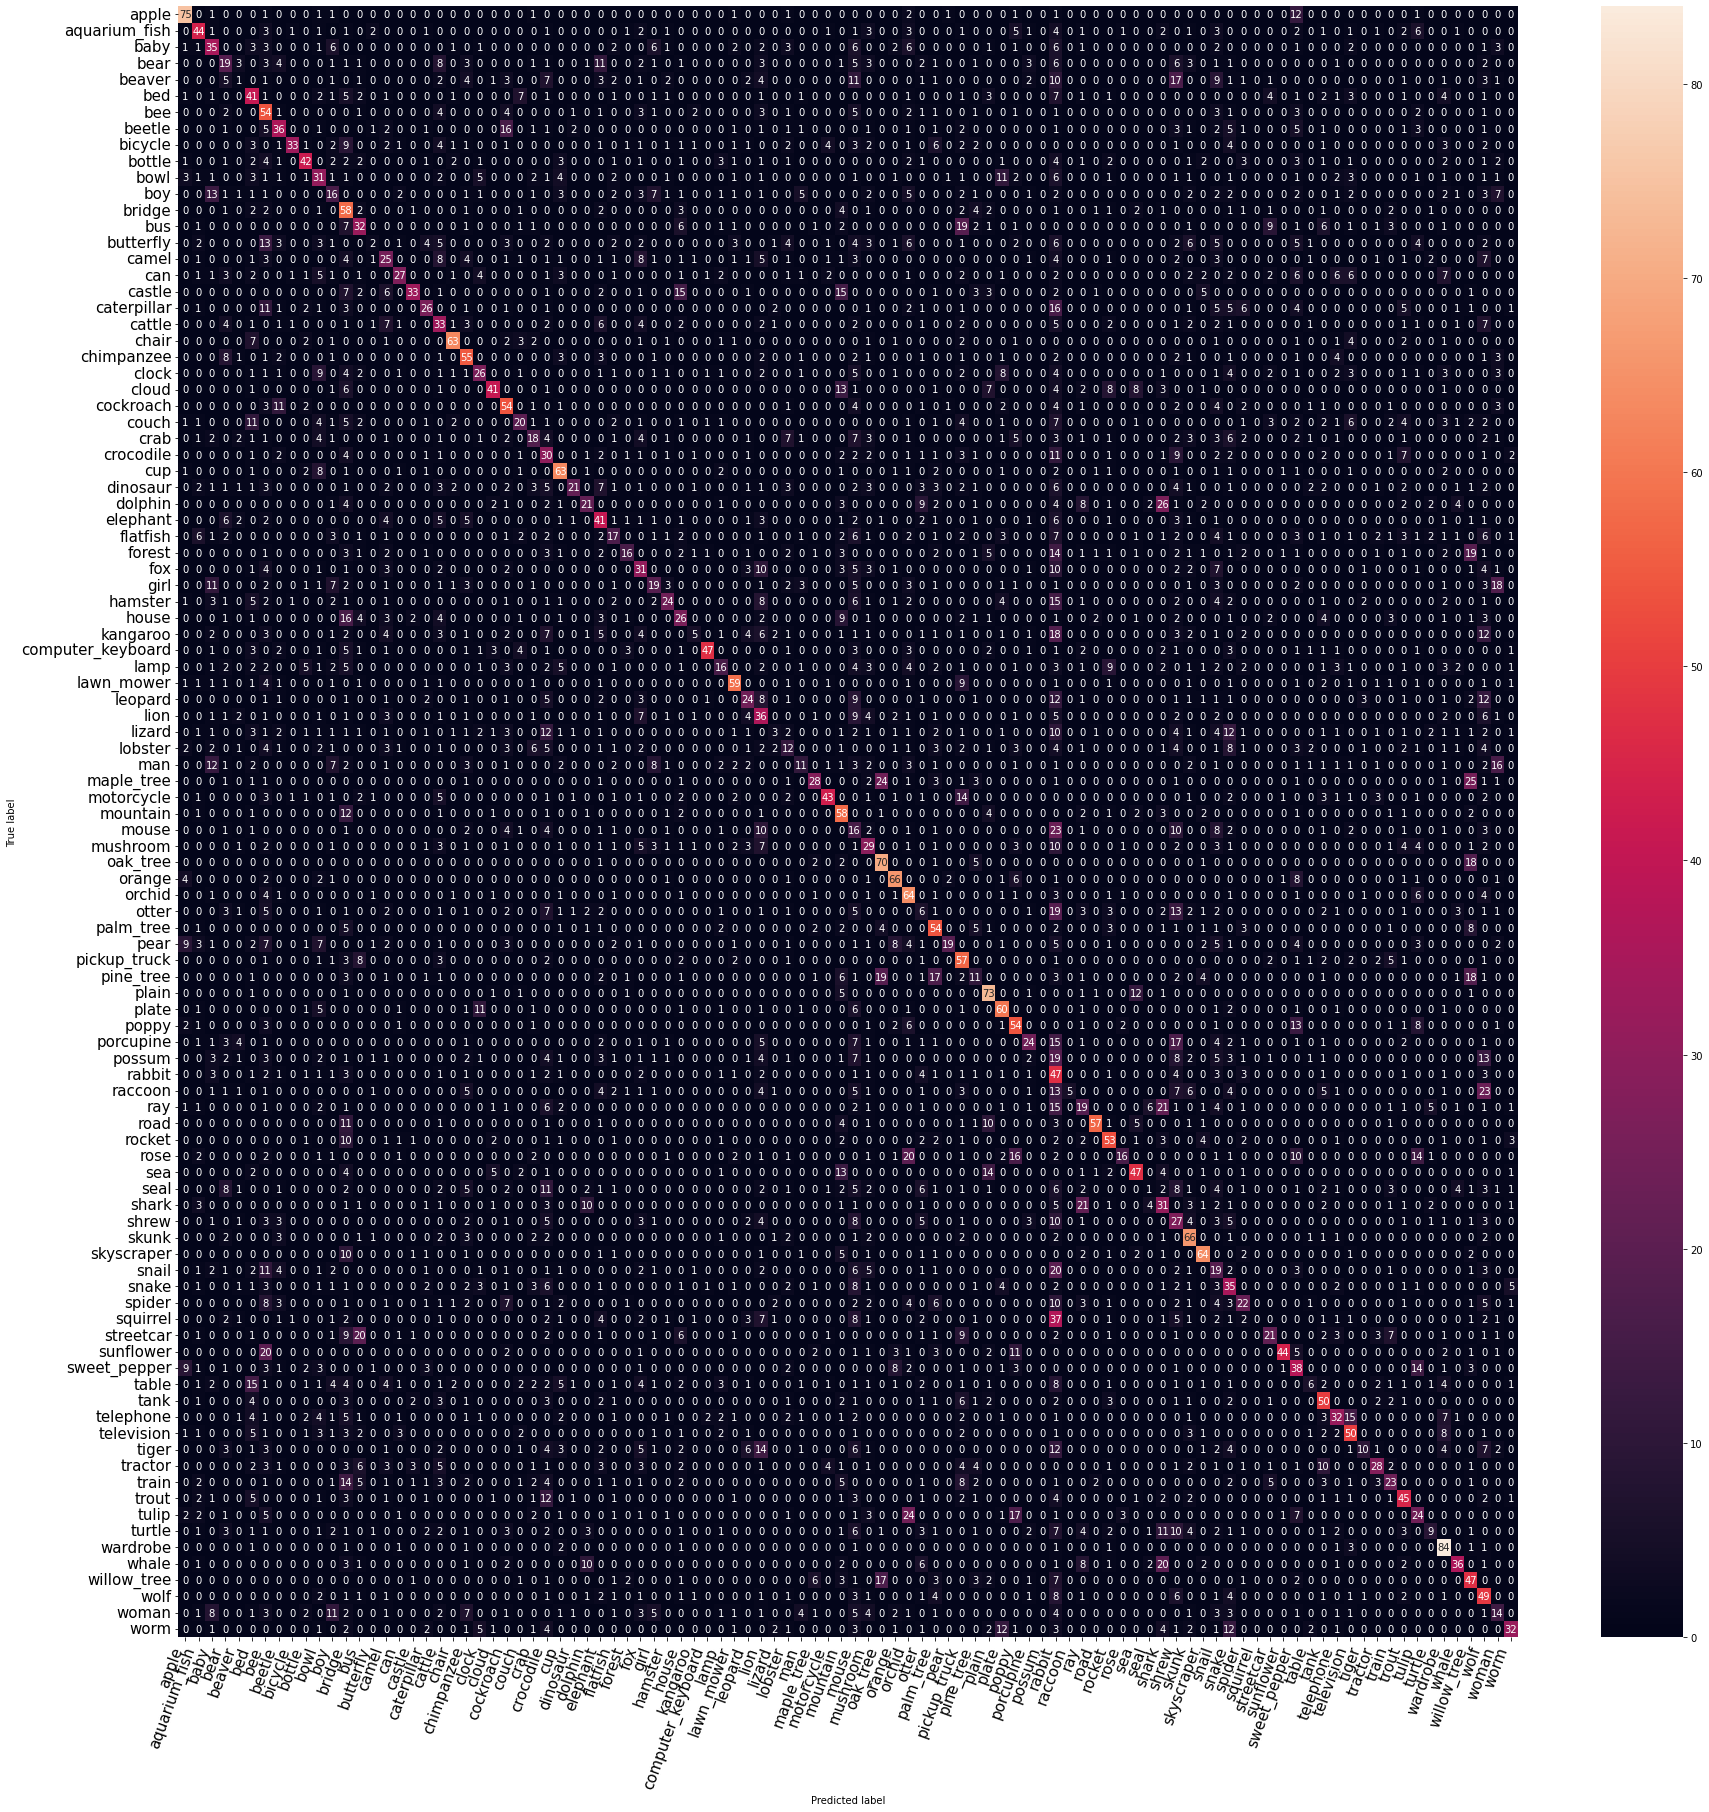

In [88]:
test_model()

In [89]:
print(history_layer3)

[{'epoch': 0, 'loss_train': 4.688729303223746, 'acc_train': 0.038197544650459776, 'acc_val': 0.07626953125}, {'epoch': 1, 'loss_train': 3.976161985981221, 'acc_train': 0.09933832911204318, 'acc_val': 0.129296875}, {'epoch': 2, 'loss_train': 3.6049549847233053, 'acc_train': 0.15962213011724607, 'acc_val': 0.178515625}, {'epoch': 3, 'loss_train': 3.3464393299453112, 'acc_train': 0.20302933674989915, 'acc_val': 0.196484375}, {'epoch': 4, 'loss_train': 3.15617913737589, 'acc_train': 0.2389190051020408, 'acc_val': 0.2462890625}, {'epoch': 5, 'loss_train': 2.9681422296835454, 'acc_train': 0.2724728953777527, 'acc_val': 0.2783203125}, {'epoch': 6, 'loss_train': 2.8431700346421223, 'acc_train': 0.2993064413265306, 'acc_val': 0.29501953125}, {'epoch': 7, 'loss_train': 2.7303218075207303, 'acc_train': 0.3188616070820361, 'acc_val': 0.29873046875}, {'epoch': 8, 'loss_train': 2.6707733614104137, 'acc_train': 0.3332669005102041, 'acc_val': 0.312109375}, {'epoch': 9, 'loss_train': 2.6551716510130436

### Train model only with layer4

In [90]:
except_layer = 'layer4'
PATH_to_save = f'./cifar_net_only_{except_layer}.pth' 
model = freeze_layers(except_layer)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
lr_scheduler = LrManager(optimizer, {0: 1.0, 50: 0.3, 100: 0.1, 150: 0.03, 200: 0.01})
criterion = nn.CrossEntropyLoss()

Train model having only layer4

-------------------  TRAINING  -------------------
epoch: 0, batch: 128, loss: 4.5446, acc: 0.0668

-------------------  TRAINING  -------------------
epoch: 1, batch: 128, loss: 3.3128, acc: 0.2055

-------------------  TRAINING  -------------------
epoch: 2, batch: 128, loss: 2.7878, acc: 0.2953

-------------------  TRAINING  -------------------
epoch: 3, batch: 128, loss: 2.5808, acc: 0.3408

-------------------  TRAINING  -------------------
epoch: 4, batch: 128, loss: 2.3939, acc: 0.3749

-------------------  TRAINING  -------------------
epoch: 5, batch: 128, loss: 2.2729, acc: 0.4013

-------------------  TRAINING  -------------------
epoch: 6, batch: 128, loss: 2.1953, acc: 0.4196

-------------------  TRAINING  -------------------
epoch: 7, batch: 128, loss: 2.1268, acc: 0.4335

-------------------  TRAINING  -------------------
epoch: 8, batch: 128, loss: 2.0885, acc: 0.4418

-------------------  TRAINING  -------------------
epoch: 9, batch: 

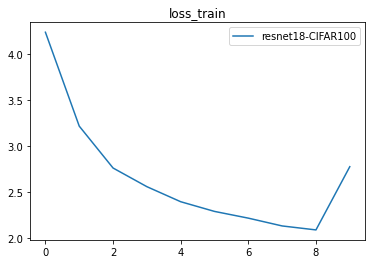

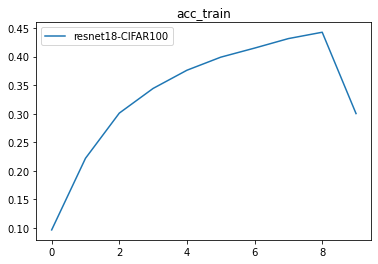

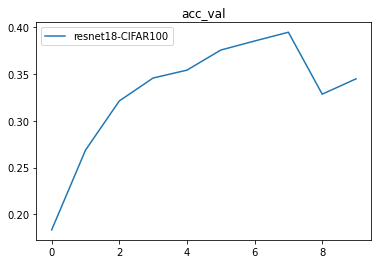

In [91]:
%%time
print("Train model having only %s" % except_layer)
train_model()
history_layer4 = history

### Show confusion matrix

Test Accuracy of the model on the 10000 test images: 34.28 %


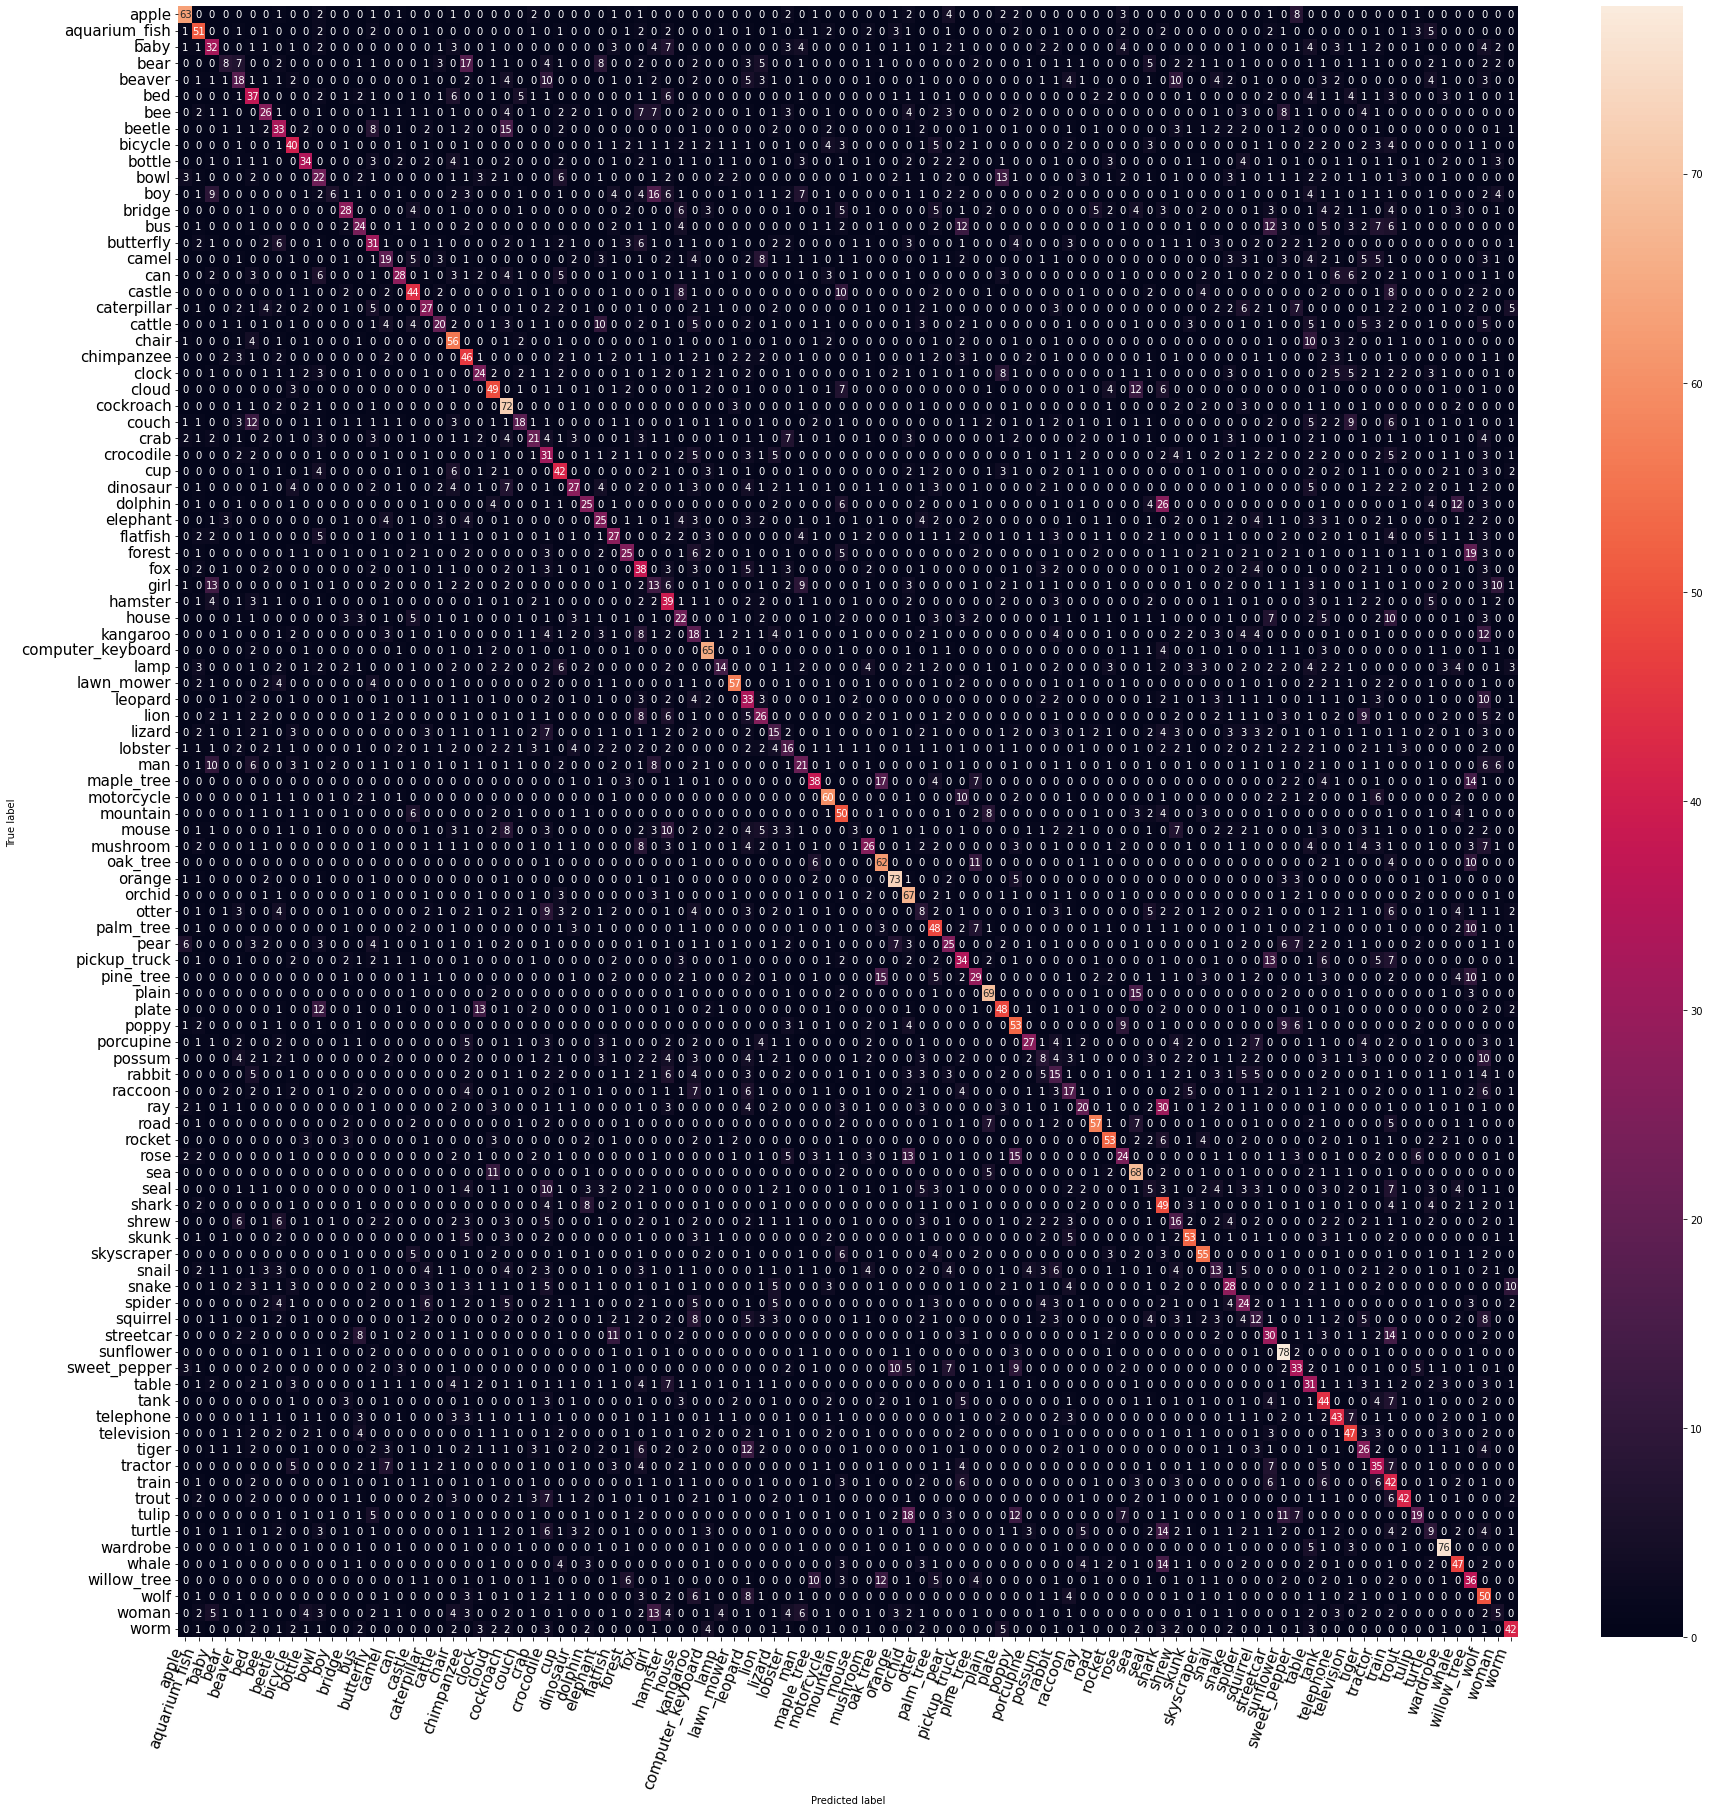

In [92]:
test_model()

In [93]:
print(history_layer4)

[{'epoch': 0, 'loss_train': 4.235278473824871, 'acc_train': 0.09629304847699038, 'acc_val': 0.18330078125}, {'epoch': 1, 'loss_train': 3.2147185486190173, 'acc_train': 0.22180325249019933, 'acc_val': 0.2685546875}, {'epoch': 2, 'loss_train': 2.7592493855223363, 'acc_train': 0.30100446422489324, 'acc_val': 0.32119140625}, {'epoch': 3, 'loss_train': 2.556434703116514, 'acc_train': 0.3442602040512221, 'acc_val': 0.345703125}, {'epoch': 4, 'loss_train': 2.392809623358201, 'acc_train': 0.37614397324469623, 'acc_val': 0.3541015625}, {'epoch': 5, 'loss_train': 2.2874149376032302, 'acc_train': 0.39902343753041053, 'acc_val': 0.3755859375}, {'epoch': 6, 'loss_train': 2.214228931130195, 'acc_train': 0.41493941326530615, 'acc_val': 0.38525390625}, {'epoch': 7, 'loss_train': 2.1294630650354893, 'acc_train': 0.4315888074283697, 'acc_val': 0.39462890625}, {'epoch': 8, 'loss_train': 2.086272631980935, 'acc_train': 0.44270966202020645, 'acc_val': 0.32841796875}, {'epoch': 9, 'loss_train': 2.7735394166

### Train model with no frozen layers

In [107]:
except_layer = 0
PATH_to_save = f'./cifar_net_only_{except_layer}.pth' 
model = freeze_layers(except_layer)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
lr_scheduler = LrManager(optimizer, {0: 1.0, 50: 0.3, 100: 0.1, 150: 0.03, 200: 0.01})
criterion = nn.CrossEntropyLoss()

Train model having all layers

-------------------  TRAINING  -------------------
epoch: 0, batch: 128, loss: 4.9486, acc: 0.0217

-------------------  TRAINING  -------------------
epoch: 1, batch: 128, loss: 4.1571, acc: 0.0603

-------------------  TRAINING  -------------------
epoch: 2, batch: 128, loss: 3.8307, acc: 0.1017

-------------------  TRAINING  -------------------
epoch: 3, batch: 128, loss: 3.4906, acc: 0.1529

-------------------  TRAINING  -------------------
epoch: 4, batch: 128, loss: 3.1807, acc: 0.2129

-------------------  TRAINING  -------------------
epoch: 5, batch: 128, loss: 2.9814, acc: 0.2531

-------------------  TRAINING  -------------------
epoch: 6, batch: 128, loss: 2.7647, acc: 0.2948

-------------------  TRAINING  -------------------
epoch: 7, batch: 128, loss: 2.5931, acc: 0.3302

-------------------  TRAINING  -------------------
epoch: 8, batch: 128, loss: 2.6174, acc: 0.3297

-------------------  TRAINING  -------------------
epoch: 9, batch: 1

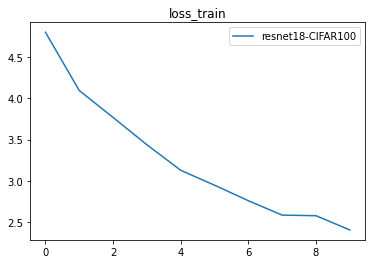

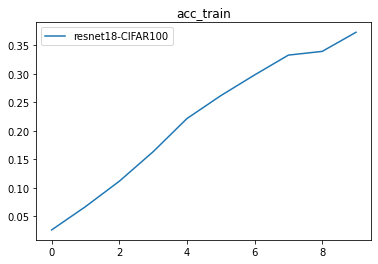

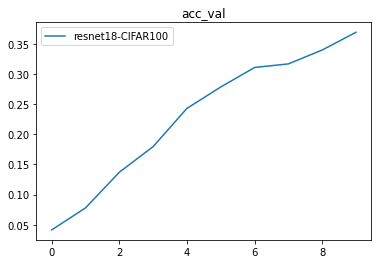

In [108]:
%%time
print("Train model having all layers")
train_model()
history_all_layers = history

Test Accuracy of the model on the 10000 test images: 37.42 %


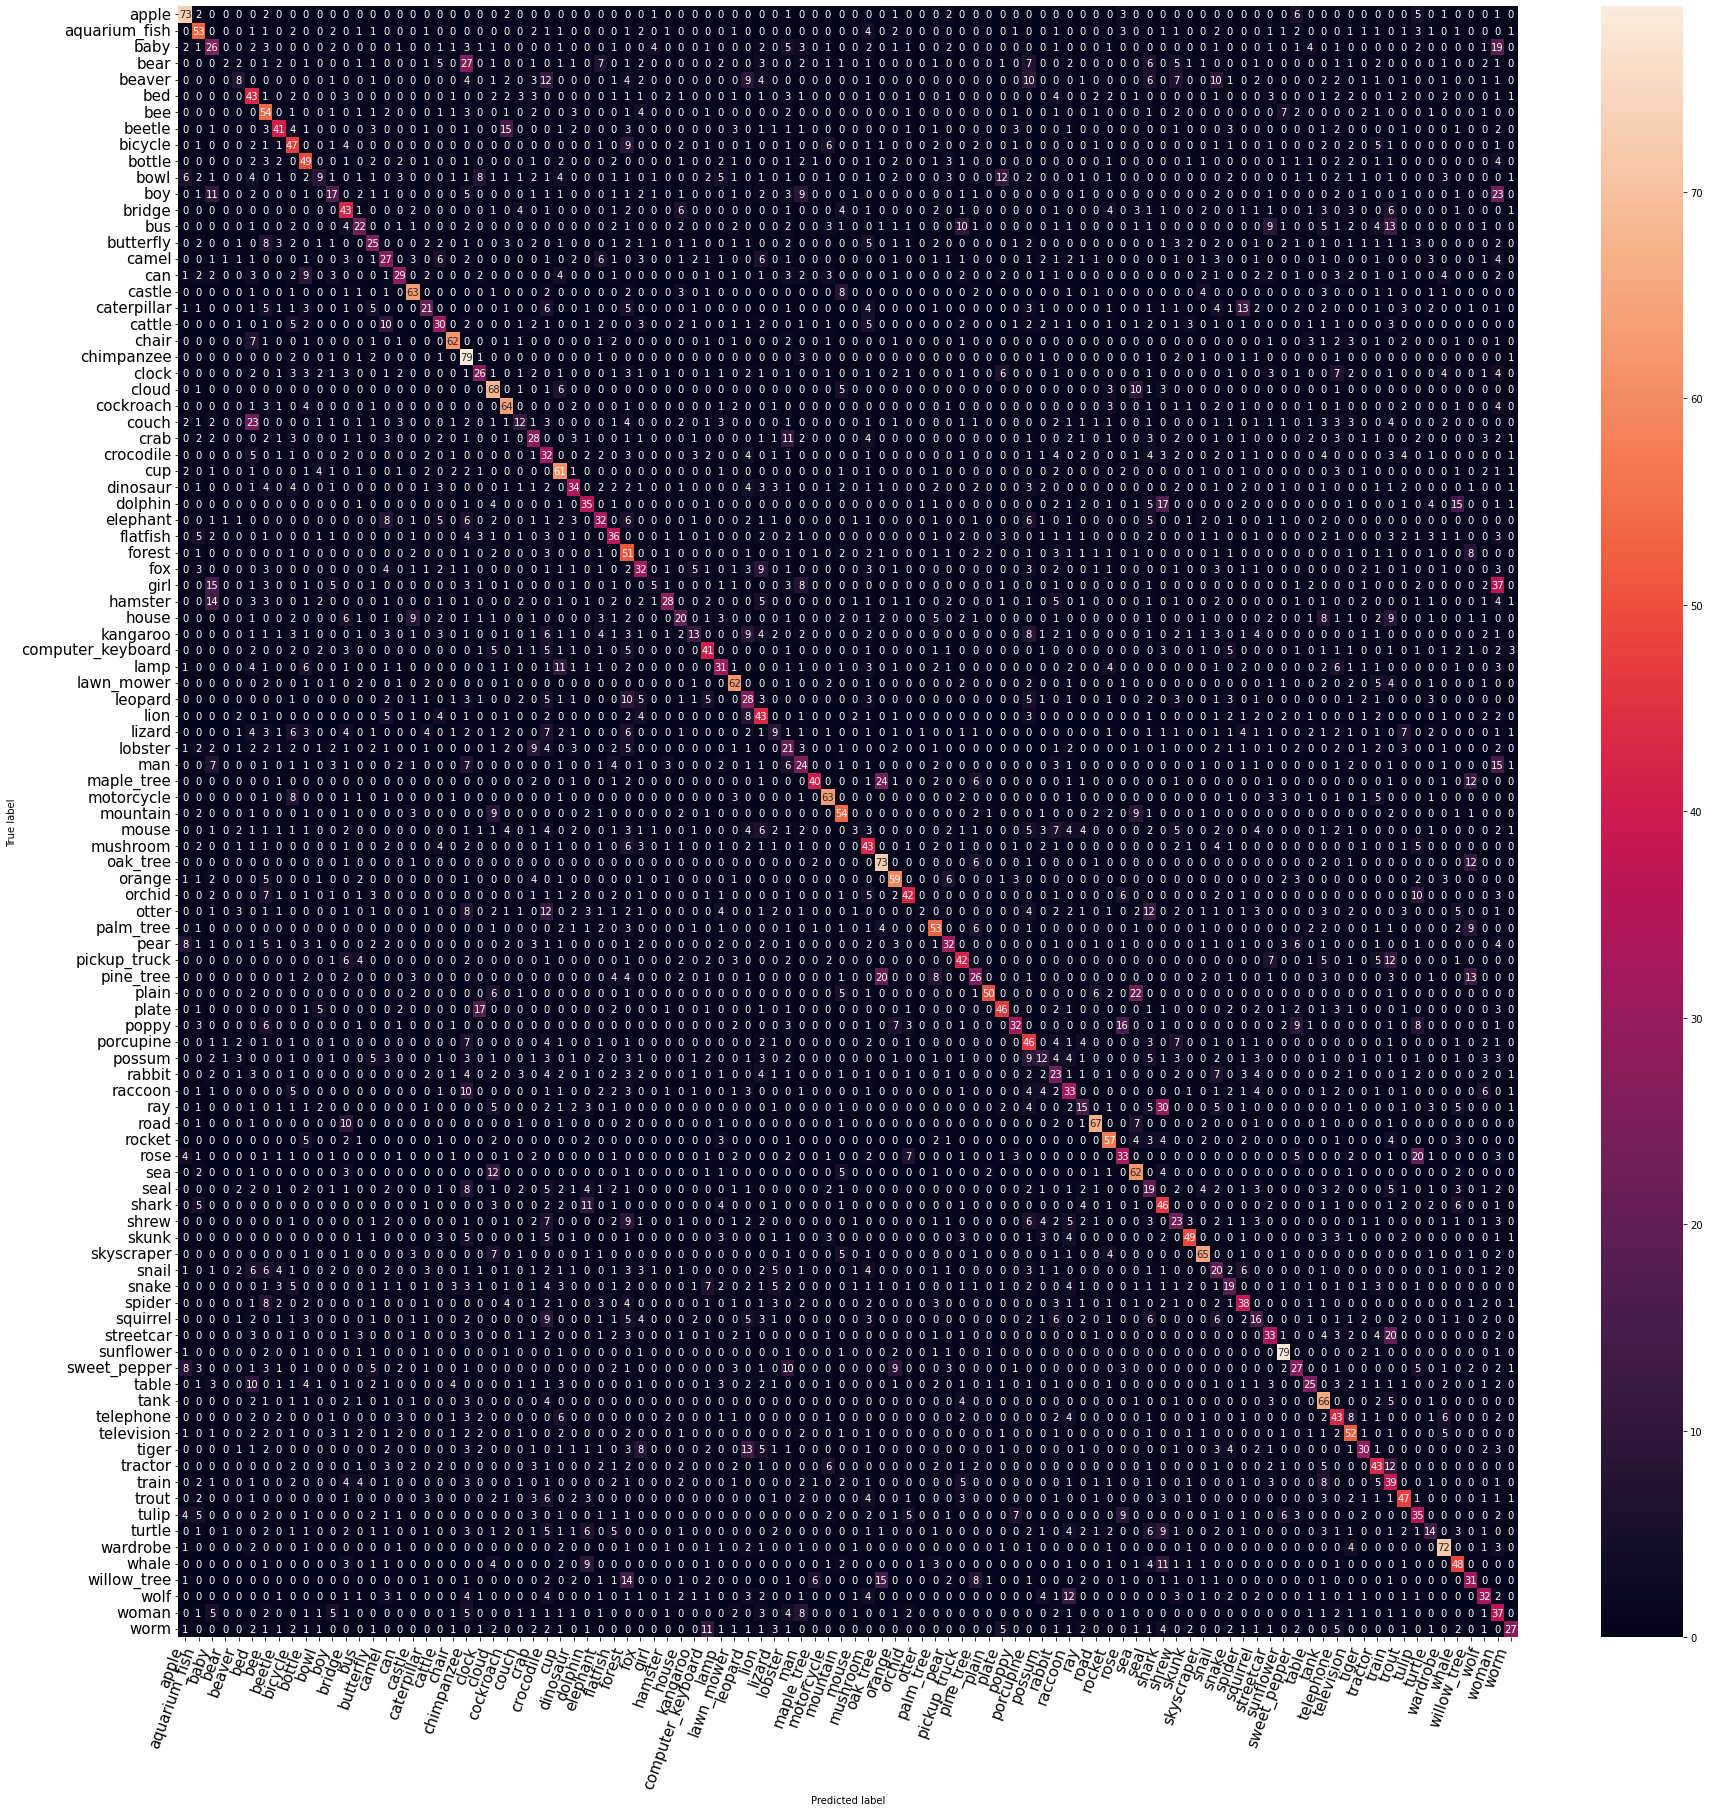

In [110]:
test_model()

In [111]:
print(history_all_layers)

[{'epoch': 0, 'loss_train': 4.805309439192013, 'acc_train': 0.026016422186274916, 'acc_val': 0.04140625}, {'epoch': 1, 'loss_train': 4.097091176071945, 'acc_train': 0.06686463647959184, 'acc_val': 0.0779296875}, {'epoch': 2, 'loss_train': 3.769583281205625, 'acc_train': 0.11142378825010085, 'acc_val': 0.137109375}, {'epoch': 3, 'loss_train': 3.4377418817306054, 'acc_train': 0.16316167090316208, 'acc_val': 0.1796875}, {'epoch': 4, 'loss_train': 3.127221665820297, 'acc_train': 0.22137276782673232, 'acc_val': 0.2431640625}, {'epoch': 5, 'loss_train': 2.9457767569288915, 'acc_train': 0.2615114795614262, 'acc_val': 0.2787109375}, {'epoch': 6, 'loss_train': 2.7572495572421016, 'acc_train': 0.29786750643837206, 'acc_val': 0.31103515625}, {'epoch': 7, 'loss_train': 2.5820035387058646, 'acc_train': 0.3327168367651044, 'acc_val': 0.3169921875}, {'epoch': 8, 'loss_train': 2.5747893063389524, 'acc_train': 0.33921795277571193, 'acc_val': 0.3400390625}, {'epoch': 9, 'loss_train': 2.4019852548229452,

### Save maximum accuracy values for each model and plot them

In [112]:
acc_val_values = []
history_layer1_acc_val = []

for epoch in history_layer1:
    history_layer1_acc_val.append(epoch['acc_val'])
acc_val_values.append(['layer1', max(history_layer1_acc_val)])

history_layer2_acc_val = []

for epoch in history_layer2:
    history_layer2_acc_val.append(epoch['acc_val'])
acc_val_values.append(['layer2', max(history_layer2_acc_val)])

history_layer3_acc_val = []

for epoch in history_layer3:
    history_layer3_acc_val.append(epoch['acc_val'])
acc_val_values.append(['layer3', max(history_layer3_acc_val)])

history_layer4_acc_val = []

for epoch in history_layer4:
    history_layer4_acc_val.append(epoch['acc_val'])
acc_val_values.append(['layer4', max(history_layer4_acc_val)])

history_all_layers_acc_val = []

for epoch in history_all_layers:
    history_all_layers_acc_val.append(epoch['acc_val'])
acc_val_values.append(['all_layers', max(history_all_layers_acc_val)])

print(acc_val_values)

[['layer1', 0.109765625], ['layer2', 0.1556640625], ['layer3', 0.32978515625], ['layer4', 0.39462890625], ['all_layers', 0.36953125]]


<BarContainer object of 5 artists>

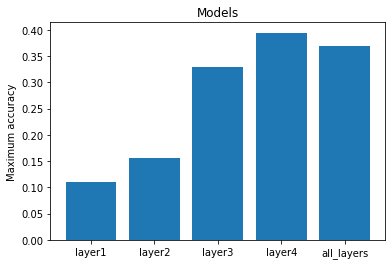

In [113]:
plt.figure()
plt.title('Models')
plt.ylabel('Maximum accuracy')
names = []
acc_val_values_list = []
for acc_value in acc_val_values:
    names.append(acc_value[0])
    acc_val_values_list.append(acc_value[1])
x = names
y = acc_val_values_list
# plt.ylim(ymin=0, ymax=3.0)
plt.bar(x, y)

<BarContainer object of 5 artists>

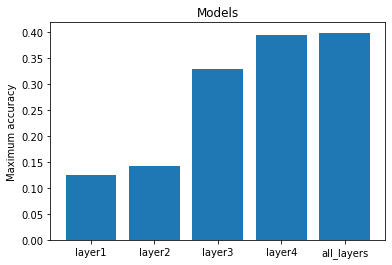

In [95]:
plt.figure()
plt.title('Models')
plt.ylabel('Maximum accuracy')
names = []
acc_val_values_list = []
for acc_value in acc_val_values:
    names.append(acc_value[0])
    acc_val_values_list.append(acc_value[1])
x = names
y = acc_val_values_list
# plt.ylim(ymin=0, ymax=3.0)
plt.bar(x, y)

## As you can see from the figure, freezing layers does affect the different classification accuracy of the model.
## This can be enough to make any analytics for the accuracy and how freezing of layers affects on accuracy overall.

## Globally, CIFAR10 / CIFAR100 are not considered to be used directly (several technincs exist to make it), since ResNet was trained on ImageNet, where the image size is 224x224, while in CIFAR it is only 32x32, but this test task does not require making the models more powerful. This is a different task. 
## Also, fine-tuning requires much more experiments with learning_rate, for example, numbers of epochs and etc. Accuracy directly depends on number of classes, fine-tuning, number of epochs and preprocessing the CIFAR100. Even different Normalize function (i.e. different values of mean and std) can affect on several percentages of accurcay for all models (frozen and whole). Also, even re-running the training with the same parameters could produce higher accuracy (two barplots to see the different of this)